In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import datasets, linear_model, metrics, feature_extraction, model_selection, tree, ensemble
from matplotlib import pyplot as plt
import seaborn as sns
import math
plt.style.use("ggplot")
%matplotlib inline
import gc
import json
from win10toast import ToastNotifier

In [ ]:
notif = ToastNotifier()

In [43]:
def daysInMonth(x):
    return 28 + ((x + math.floor(x / 8)) % 2 + (2 % x) + (2 * math.floor(1/x)))


daysFromYearStart = [0]
def getDaysFromYearStart(month, day):
    while len(daysFromYearStart) <= month:
        l = len(daysFromYearStart)
        daysFromYearStart.append(daysFromYearStart[l - 1] + daysInMonth(l))
    return daysFromYearStart[month] - (daysInMonth(month) - day)


def dropRare(frame, clsName, minCount):
    counts = frame[clsName].value_counts()
    frame.drop(frame[frame[clsName].isin(counts[counts < minCount].index)].index, inplace=True)

def logit(x):
    return math.log(np.abs(x / (1 - x)))

def logit_vec(v):
    return logit(v.mean() + 1e-5)

def reclassMeanOpt(frame, targetSrc, clsName, meanName, drop=False):
    if meanName in frame.columns:
        if drop:
            print("%s found in dataframe, drop=True, dropping" % meanName)
            frame = frame.drop(meanName, axis=1)
        else:
            print("%s found in dataframe, drop=False, skipping" % meanName)
            return frame
    mean_frame = targetSrc[[clsName, 'target']].groupby(clsName).agg(logit_vec).reset_index()
    mean_frame.rename(columns={'target':meanName}, inplace = True)
    return pd.merge(frame, mean_frame, on=clsName, how='left')
    
    
def reclassMean(frame, targetSrc, clsName, meanName, targetExtractor = lambda f, c: f[[c, 'target']].groupby(c).mean(), excluders=[]):
    def getMean(c): 
        if c not in meanInfo or c in excluders:
            meanInfo[c] = meanInfo.mean()
        return meanInfo[c]
    meanInfo = targetExtractor(targetSrc, clsName)
    frame[meanName] = frame[clsName].map(lambda c: getMean(c))
        
    
def split_time(time):
    time = str(int(time))
    time = ('0' * (4 - len(time))) + time
    hours = int(time[0:2])
    minutes = int(time[2:4])
    return {"H": hours, "M": minutes}


def reclass_time(frame, orig, hours, minutes): 
    t = frame[orig].map(split_time)
    frame[hours] = t.map(lambda t: t["H"])
    frame[minutes] = t.map(lambda t: t["M"])
    
def roc_curve(label, pred):
    fpr, tpr, _ = metrics.roc_curve(label, pred[:,1])
    plt.plot(fpr, tpr, label = 'linear model')
    plt.fill(fpr, tpr, alpha=0.5)
    plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right");
    plt.show()

In [44]:
train_df = pd.read_csv("train_dataset.csv").dropna()
train_df.drop(train_df[train_df['AirTime'] == 0].index, inplace=True)
dropRare(train_df, "FlightNum", 20)
dropRare(train_df, "Dest", 5)
dropRare(train_df, "Origin", 5)

test_df = pd.read_csv("test_dataset.csv").fillna(0)

In [45]:
df = pd.concat((train_df, test_df)).reset_index().drop('index', axis=1)

In [46]:
df['DayOfYear'] = df[['Month', 'DayofMonth']].apply(lambda x: getDaysFromYearStart(x["Month"], x["DayofMonth"]), axis=1)

In [47]:
df["AirTimeFrame"] = df["AirTime"].map(lambda x: math.log((x // 30) + 1, 10))

In [48]:
reclass_time(df, "DepTime", "DepHour", "DepMinute")
df["DepTotalMinutes"] = df["DepHour"] * 60 + df["DepMinute"]
df["DepTimeFrame"] = df["DepTotalMinutes"] // 15
df["DepHourOfYear"] = df["DayOfYear"] * 24 - (24 - df["DepHour"])

In [49]:
reclass_time(df, "ArrTime", "ArrHour", "ArrMinute")
df["ArrTotalMinutes"] = df["ArrHour"] * 60 + df["ArrMinute"]
df["ArrTimeFrame"] = df["ArrTotalMinutes"] // 15
df["ArrHourOfYear"] = df["DayOfYear"] * 24 - (24 - df["ArrHour"])

In [50]:
df["DistanceFrame"] = df["Distance"].map(lambda x: math.log((x // 30) + 1, 2))

In [51]:
gc.collect()
df["DepHourOfYearFrame"] = df["DepHourOfYear"] // 8
dhoy_origin_mean = df.groupby(["DepHourOfYearFrame", "Origin"])["target"].agg(logit_vec).reset_index()
dhoy_origin_mean.rename(columns={'target': 'DHOY_OriginChance'}, inplace=True)
df = pd.merge(df, dhoy_origin_mean, on=['DepHourOfYearFrame', 'Origin'], how='left')

In [52]:
gc.collect()
df["ArrHourOfYearFrame"] = df["ArrHourOfYear"] // 8
ahoy_dest_mean = df.groupby(["ArrHourOfYearFrame", "Dest"])["target"].agg(logit_vec).reset_index()
ahoy_dest_mean.rename(columns={'target': 'AHOY_DestChance'}, inplace=True)
df = pd.merge(df, ahoy_dest_mean, on=['ArrHourOfYearFrame', 'Dest'], how='left')

In [53]:
with open('airport_info.json', 'r') as data_file:
    airport_data = json.load(fp = data_file)
    df["OTimeZone"] = df["Origin"].map(lambda x: airport_data[x]['Time Zone'])
    df["OLatitude"] = df["Origin"].map(lambda x: airport_data[x]['Latitude'])
    df["OLongitude"] = df["Origin"].map(lambda x: airport_data[x]['Longitude'])
    
    df["DTimeZone"] = df["Dest"].map(lambda x: airport_data[x]['Time Zone'])
    df["DLatitude"] = df["Dest"].map(lambda x: airport_data[x]['Latitude'])
    df["DLongitude"] = df["Dest"].map(lambda x: airport_data[x]['Longitude'])

In [54]:
df["OTimeZone"] = df["OTimeZone"].map(lambda x: int(x.split(':')[0]))
df["DTimeZone"] = df["DTimeZone"].map(lambda x: int(x.split(':')[0]))

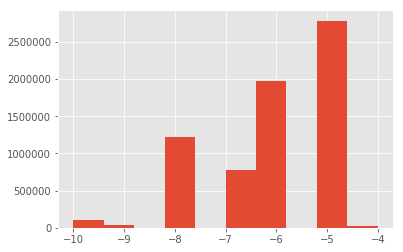

In [169]:
df["OTimeZone"].hist()

In [129]:
df["TimeZoneDiff"] = df["OTimeZone"] - df["DTimeZone"]

In [55]:
df["OLtFrame"] = df["OLatitude"].astype('float').agg('floor')
df["DLtFrame"] = df["DLatitude"].astype('float').agg('floor')

df["OLgFrame"] = df["OLongitude"].astype('float').agg('floor')
df["DLgFrame"] = df["DLongitude"].astype('float').agg('floor')

In [56]:
df.columns

Index(['AirTime', 'ArrTime', 'DayOfWeek', 'DayofMonth', 'DepTime', 'Dest',
       'Distance', 'FlightNum', 'Id', 'Month', 'Origin', 'TailNum', 'TaxiIn',
       'TaxiOut', 'UniqueCarrier', 'target', 'DayOfYear', 'AirTimeFrame',
       'DepHour', 'DepMinute', 'DepTotalMinutes', 'DepTimeFrame',
       'DepHourOfYear', 'ArrHour', 'ArrMinute', 'ArrTotalMinutes',
       'ArrTimeFrame', 'ArrHourOfYear', 'DistanceFrame', 'DepHourOfYearFrame',
       'DHOY_OriginChance', 'ArrHourOfYearFrame', 'AHOY_DestChance',
       'OTimeZone', 'OLatitude', 'OLongitude', 'DTimeZone', 'DLatitude',
       'DLongitude', 'OLtFrame', 'DLtFrame', 'OLgFrame', 'DLgFrame'],
      dtype='object')

In [134]:
train_df_upd = df[:len(train_df)].drop('Id', axis=1)

In [135]:
mean_names = {
    "UniqueCarrier": "CarrierChance",
    "Origin": "OriginChance",
    "Dest": "DestChance",
    "FlightNum": "FlightChance",
    "DepHourOfYear": "DHOYChance",
    "ArrHourOfYear": "AHOYChance",
    "TailNum": "PlaneChance",
    "AirTimeFrame": "AirFrameChance",
    "DepTimeFrame": "DepFrameChance",
    "ArrTimeFrame": "ArrFrameChance",
    "OTimeZone": "OTZChance",
    "DTimeZone": "DTZChance",
    "OLtFrame": "OLtChance",
    "DLtFrame": "DLtChance",
    "OLgFrame": "OLgChance",
    "DLgFrame": "DLgChance",
    "TimeZoneDiff": "TZDChance"
}

In [136]:
for orig, mean in mean_names.items():
    df = reclassMeanOpt(df, train_df_upd, orig, mean)
    gc.collect()
    print("%s:%s" % (orig, mean))

CarrierChance found in dataframe, drop=False, skipping
UniqueCarrier:CarrierChance
OriginChance found in dataframe, drop=False, skipping
Origin:OriginChance
DestChance found in dataframe, drop=False, skipping
Dest:DestChance
FlightChance found in dataframe, drop=False, skipping
FlightNum:FlightChance
DHOYChance found in dataframe, drop=False, skipping
DepHourOfYear:DHOYChance
AHOYChance found in dataframe, drop=False, skipping
ArrHourOfYear:AHOYChance
PlaneChance found in dataframe, drop=False, skipping
TailNum:PlaneChance
AirFrameChance found in dataframe, drop=False, skipping
AirTimeFrame:AirFrameChance
DepFrameChance found in dataframe, drop=False, skipping
DepTimeFrame:DepFrameChance
ArrFrameChance found in dataframe, drop=False, skipping
ArrTimeFrame:ArrFrameChance
OTZChance found in dataframe, drop=False, skipping
OTimeZone:OTZChance
DTZChance found in dataframe, drop=False, skipping
DTimeZone:DTZChance
OLtChance found in dataframe, drop=False, skipping
OLtFrame:OLtChance
DLtChan

In [104]:
df["Dest_label"] = df["Dest"].astype('category').cat.codes
df["Origin_label"] = df["Origin"].astype('category').cat.codes
df["Plane_label"] = df["TailNum"].astype('category').cat.codes
df["Carrier_label"] = df["UniqueCarrier"].astype('category').cat.codes

In [137]:
df.columns

Index(['AirTime', 'ArrTime', 'DayOfWeek', 'DayofMonth', 'DepTime', 'Dest',
       'Distance', 'FlightNum', 'Id', 'Month', 'Origin', 'TailNum', 'TaxiIn',
       'TaxiOut', 'UniqueCarrier', 'target', 'DayOfYear', 'AirTimeFrame',
       'DepHour', 'DepMinute', 'DepTotalMinutes', 'DepTimeFrame',
       'DepHourOfYear', 'ArrHour', 'ArrMinute', 'ArrTotalMinutes',
       'ArrTimeFrame', 'ArrHourOfYear', 'DistanceFrame', 'DepHourOfYearFrame',
       'DHOY_OriginChance', 'ArrHourOfYearFrame', 'AHOY_DestChance',
       'OTimeZone', 'OLatitude', 'OLongitude', 'DTimeZone', 'DLatitude',
       'DLongitude', 'OLtFrame', 'DLtFrame', 'OLgFrame', 'DLgFrame',
       'CarrierChance', 'OriginChance', 'DestChance', 'FlightChance',
       'DHOYChance', 'AHOYChance', 'PlaneChance', 'AirFrameChance',
       'DepFrameChance', 'ArrFrameChance', 'OTZChance', 'DTZChance',
       'OLtChance', 'DLtChance', 'OLgChance', 'DLgChance', 'Dest_label',
       'Origin_label', 'Carrier_label', 'Plane_label', 'TimeZoneDiff',

In [162]:
reg_used_cols = ["AirFrameChance",
             "DepFrameChance",
             "ArrFrameChance",
             "FlightChance",
             "DHOYChance",
             "AHOYChance",
             "OriginChance",
             "DestChance",
             "CarrierChance",
             "TaxiIn",
             "TaxiOut",
             "DHOY_OriginChance",
             "AHOY_DestChance",
             "TZDChance"
            ]
'''num_cols_dec = ['AirTime', 'Distance', 'TaxiIn', 'TaxiOut',
                'DepTotalMinutes', 'ArrTotalMinutes',
                'Origin_label', 'Dest_label', 'DHOY_OriginChance', 'AHOY_DestChance']
cat_cols_dec = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'TimeZoneDiff']'''
num_cols_dec = ['AirTime', 'ArrTime', 'DepTime', 'Distance', 'TaxiIn', 'TaxiOut',
                'FlightChance', 'PlaneChance']
cat_cols_dec = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier']
dec_used_cols = num_cols_dec + cat_cols_dec
cols_drop_dec = [x for x in reg_used_cols if x not in dec_used_cols]
merged_df = pd.get_dummies(df[list(set(dec_used_cols + reg_used_cols)) + ['target']], columns=cat_cols_dec)

In [163]:
train_df_upd = merged_df[:len(train_df)]
test_df_upd = merged_df[len(train_df):].drop('target', axis=1).reset_index().drop('index', axis=1)

In [164]:
labels = train_df_upd["target"]
data_train, data_test, label_train, label_test = model_selection.train_test_split(
    train_df_upd.drop("target", axis=1),
    labels,
    test_size = 0.3)
gc.collect()

11733

In [165]:
dec = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=3)

In [166]:
dec.fit(data_train.drop(cols_drop_dec, axis=1), label_train)
try:
    notif.show_toast("Random forest complete!", "Come HERE!!!!", duration=1)
except:
    pass

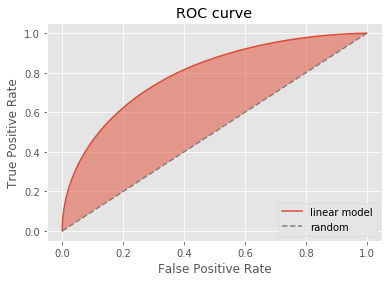

0.794839681618


In [167]:
dec_pred = dec.predict_proba(data_test.drop(cols_drop_dec, axis=1))
roc_curve(label_test, dec_pred)
print(metrics.roc_auc_score(label_test, dec_pred[:,1]))

0.850897524434

In [145]:
clf = linear_model.LogisticRegression()
param_grid = {'C': [0.01, 0.1, 1, 5]}
opt = model_selection.GridSearchCV(clf, param_grid, cv=3, n_jobs=2, return_train_score=True, scoring='roc_auc')

In [146]:
opt.fit(data_train[reg_used_cols], label_train)
gc.collect()
for i, c in enumerate(opt.best_estimator_.coef_[0]):
    print("%s: %f" % (data_train[reg_used_cols].columns[i], c))

AirFrameChance: 0.167706
DepFrameChance: 0.361875
ArrFrameChance: 0.042718
FlightChance: 0.414509
DHOYChance: -0.175544
AHOYChance: -0.037369
OriginChance: -0.192212
DestChance: -0.093314
CarrierChance: 0.637753
TaxiIn: -0.011953
TaxiOut: 0.002649
DHOY_OriginChance: 0.714795
AHOY_DestChance: 0.612871
TZDChance: 0.253833


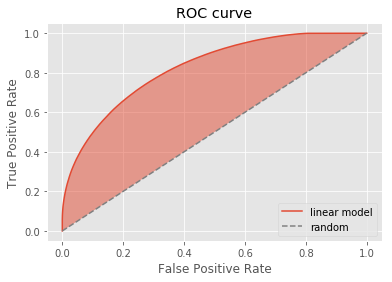

0.823231515475


In [147]:
reg_pred = opt.predict_proba(data_test[reg_used_cols])
roc_curve(label_test, reg_pred)
print(metrics.roc_auc_score(label_test, reg_pred[:,1]))

0.823378147562

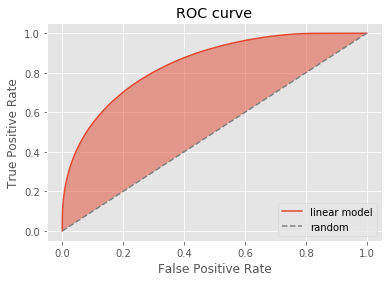

0.844178427181


In [148]:
mean_pred = (reg_pred + dec_pred) / 2
roc_curve(label_test, mean_pred)
print(metrics.roc_auc_score(label_test, mean_pred[:,1]))

0.844178427181

In [126]:
from os import system
def save_df(pred):
    df_to_save = pd.DataFrame(pred[:, 1], columns=["Prediction1"])
    df_to_save.index.name = "Id"
    df_to_save.to_csv("pred.csv")
    system("gzip pred.csv")
    df_to_save = None
    gc.collect()

In [119]:
test_df_upd.fillna(0, inplace=True)

In [120]:
dec_pred_test = dec.predict_proba(test_df_upd.drop(cols_drop_dec, axis=1))
reg_pred_test = opt.predict_proba(test_df_upd[reg_used_cols])
mean_pred_test = (dec_pred_test + reg_pred_test) / 2

In [127]:
save_df(dec_pred_test)